<a href="https://colab.research.google.com/github/sjsu-cs133-f25/cyberbugs-cybersecurity-incidents/blob/main/notebooks/05_predictive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Model
**Goal:** implement multiple models (logistic regression, random forest, eXtreme Gradient Boosting, and deep neural network) to predict the severity level of an incident and evaluate them to see which one fits the data best

## Load data


In [1]:
# Imports
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np

# Correct filename from os.listdir
file_path = "GUIDE_Train.csv"

# Load only the first 1,000,000 rows
df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "Microsoft/microsoft-security-incident-prediction",
    file_path,
    pandas_kwargs={"nrows": 1_000_000}
).sample(100000)

print("Shape:", df.shape)
print("First 5 records:\n", df.head())

Using Colab cache for faster access to the 'microsoft-security-incident-prediction' dataset.


/usr/local/lib/python3.12/dist-packages/kagglehub/pandas_datasets.py:91: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  result = read_function(


Shape: (100000, 45)
First 5 records:
                   Id  OrgId  IncidentId  AlertId                 Timestamp  \
516281  687194771882    715       77746   408889  2024-06-07T15:11:13.000Z   
563703  489626274848     55       24205    15569  2024-06-15T03:35:45.000Z   
834901  627065226973     45       55163   365072  2024-06-11T20:30:20.000Z   
468823  566935685388    569      158878  1469080  2024-06-03T11:07:00.000Z   
356788  936302871145    558      237335  1472977  2024-06-13T23:20:51.000Z   

        DetectorId  AlertTitle       Category  MitreTechniques  IncidentGrade  \
516281           0           0  InitialAccess  T1078;T1078.004   TruePositive   
563703         110          86  InitialAccess              NaN   TruePositive   
834901           6           5  InitialAccess            T1566  FalsePositive   
468823          25          17  InitialAccess              NaN  FalsePositive   
356788           6           5  InitialAccess            T1566   TruePositive   

      

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing

In [3]:
# drop features with high % missing data
null_cols = ["MitreTechniques",
             "ActionGrouped",
             "ActionGranular",
             "EmailClusterId",
             "ThreatFamily",
             "ResourceType",
             "Roles",
             "AntispamDirection",
             "SuspicionLevel",
             "LastVerdict"
             ]

df = df.drop(null_cols, axis=1)

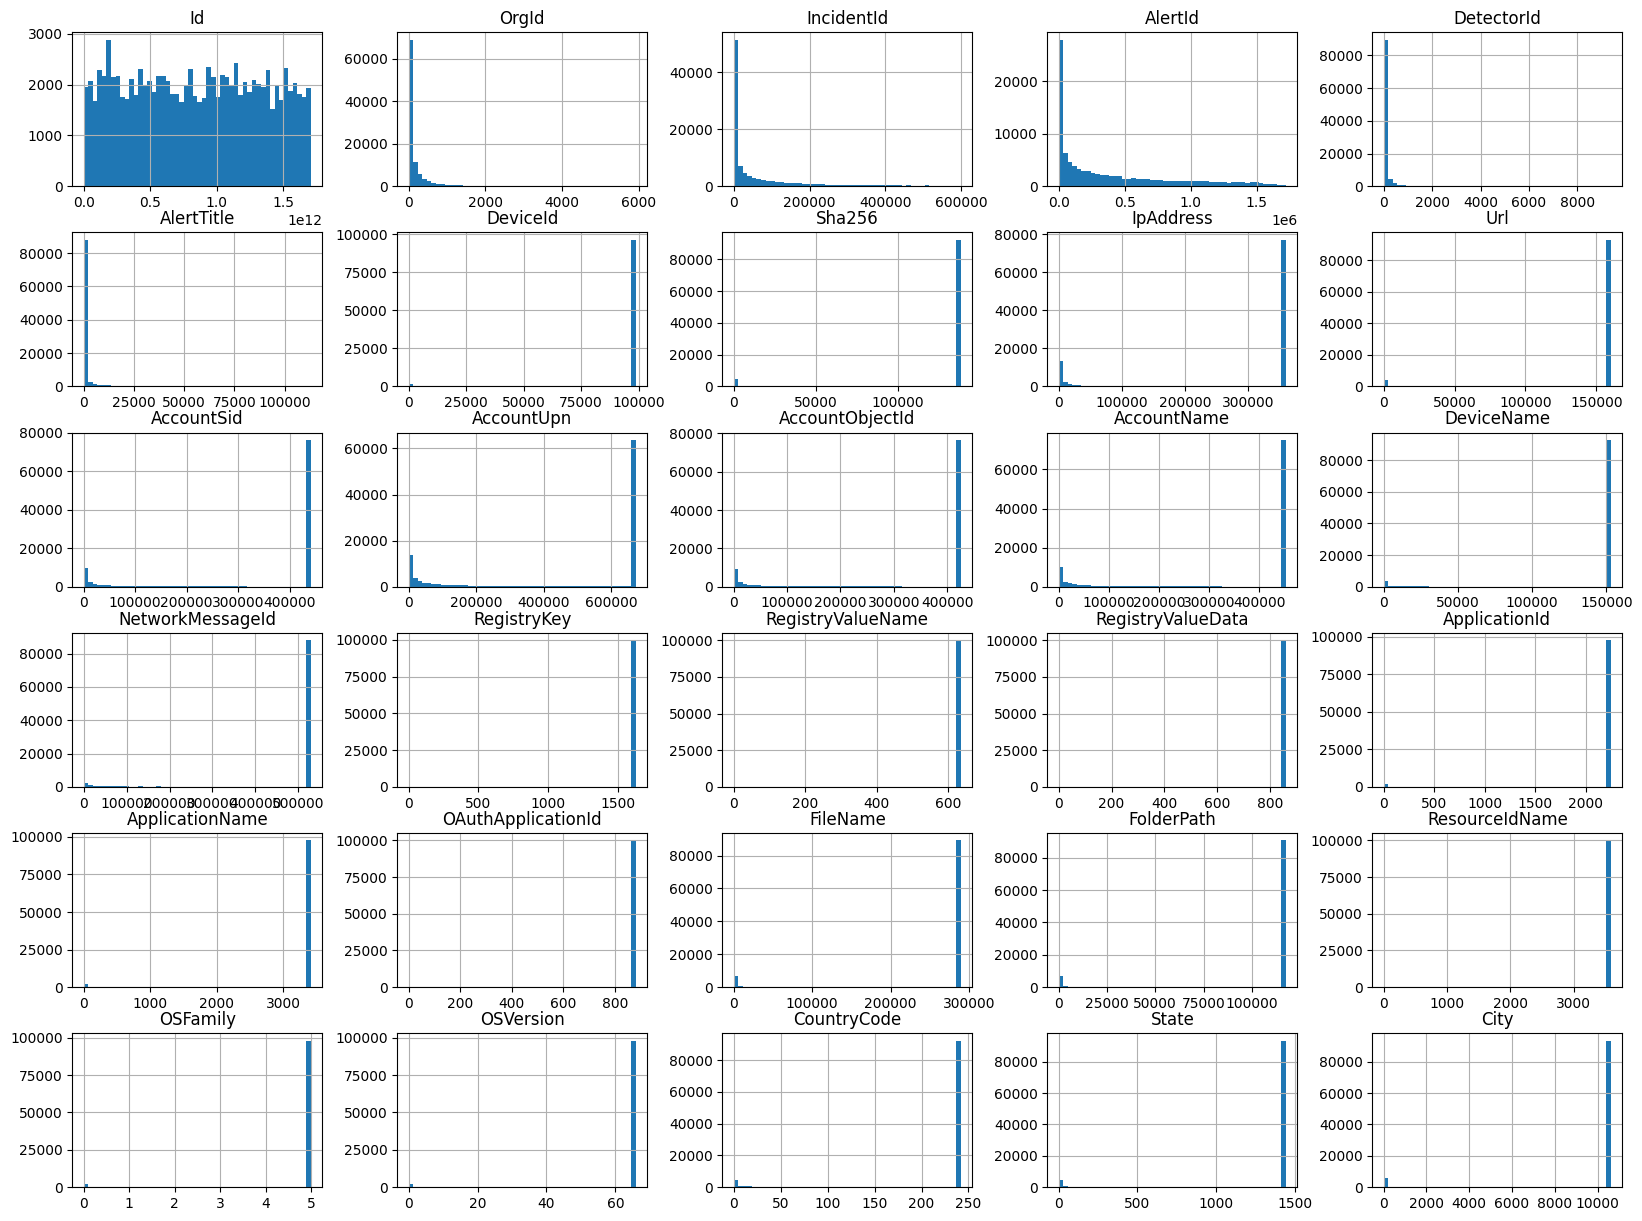

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

## Build models

In [14]:
# Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight

In [6]:
# keep valid labels only
valid_labels = ["TruePositive", "BenignPositive", "FalsePositive"]
df_new = df[df["IncidentGrade"].isin(valid_labels)].copy()

le = LabelEncoder()
df_new["target"] = le.fit_transform(df_new["IncidentGrade"])
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# drop columns with little to no predictive power
drop_cols = ["IncidentGrade", "Id", "AlertTitle", "Timestamp"]
df_new = df_new.drop(columns=drop_cols)

# fill missing values
df_new = df_new.fillna(-1)

# separate numeric and categorical cols
num_cols = df_new.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove("target")
cat_cols = df_new.select_dtypes(include=["object"]).columns.tolist()

Label mapping: {'BenignPositive': np.int64(0), 'FalsePositive': np.int64(1), 'TruePositive': np.int64(2)}


In [7]:
X = df_new.drop("target", axis=1)
y = df_new["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [8]:
# preprocessing
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
        ])

#### Logistic Regression model

In [9]:
# build Logistic Regression pipeline
lr_model = Pipeline([
    ("preprocess", preprocess),
    ("classifier", LogisticRegression(max_iter=1000, multi_class="ovr", solver="lbfgs"))
])

lr_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Category', 'EntityType',
                                                   'EvidenceRole']),
                                                 ('num', 'passthrough',
                                                  ['OrgId', 'IncidentId',
                                                   'AlertId', 'DetectorId',
                                                   'DeviceId', 'Sha256',
                                                   'IpAddress', 'Url',
                                                   'AccountSid', 'AccountUpn',
                                                   'AccountObjectId',
                                                   'AccountName', 'DeviceName',
                                                   'NetworkMessageId',
                                                   'RegistryKey',
                                                   'RegistryValueName',
                                                   'RegistryValueData',
                                                   'ApplicationId',
                                                   'ApplicationName',
                                                   'OAuthApplicationId',
                                                   'FileName', 'FolderPath',
                                                   'ResourceIdName', 'OSFamily',
                                                   'OSVersion', 'CountryCode',
                                                   'State', 'City'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, multi_class='ovr'))])

In [11]:
# check accuracy
y_pred = lr_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc, "\n")

# show precision, recall, F1 score for each class
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.5759659068065774 

                precision    recall  f1-score   support

BenignPositive       0.57      0.74      0.64     10738
 FalsePositive       0.47      0.16      0.24      5360
  TruePositive       0.61      0.63      0.62      8775

      accuracy                           0.58     24873
     macro avg       0.55      0.51      0.50     24873
  weighted avg       0.56      0.58      0.55     24873



#### Random Forest model

In [13]:
# Build Random Forest Pipeline
rf_model = Pipeline([
    ("preprocess", preprocess),
    ("classifier", RandomForestClassifier(
        n_estimators=200,           # Number of trees
        max_depth=20,               # Maximum depth of trees
        min_samples_split=10,       # Minimum samples to split a node
        min_samples_leaf=4,         # Minimum samples in leaf node
        class_weight='balanced',    # Handle class imbalance
        random_state=42,
        n_jobs=-1,
        verbose=1
    ))
])
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   38.6s finished


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Category', 'EntityType',
                                                   'EvidenceRole']),
                                                 ('num', 'passthrough',
                                                  ['OrgId', 'IncidentId',
                                                   'AlertId', 'DetectorId',
                                                   'DeviceId', 'Sha256',
                                                   'IpAddress', 'Url',
                                                   'AccountSid', 'AccountUpn',
                                                   'AccountObjectId',
                                                   'AccountName', 'DeviceName',
                                                   'NetworkMessageId',
                                                   'Regis...
                                                   'RegistryValueName',
                                                   'RegistryValueData',
                                                   'ApplicationId',
                                                   'ApplicationName',
                                                   'OAuthApplicationId',
                                                   'FileName', 'FolderPath',
                                                   'ResourceIdName', 'OSFamily',
                                                   'OSVersion', 'CountryCode',
                                                   'State', 'City'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        min_samples_leaf=4,
                                        min_samples_split=10, n_estimators=200,
                                        n_jobs=-1, random_state=42,
                                        verbose=1))])

In [15]:
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred,
                          target_names=le.classes_,
                          digits=4))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s



Classification Report:
                precision    recall  f1-score   support

BenignPositive     0.8029    0.9200    0.8575     10738
 FalsePositive     0.8072    0.7985    0.8029      5360
  TruePositive     0.9456    0.7831    0.8568      8775

      accuracy                         0.8455     24873
     macro avg     0.8519    0.8339    0.8390     24873
  weighted avg     0.8542    0.8455    0.8454     24873



[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished


#### XGB Classifier model

In [16]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
sample_weights = np.array([class_weights[i] for i in y_train])

In [17]:
xgb_model = Pipeline([
    ("preprocess", preprocess),
    ("classifier", XGBClassifier(
        n_estimators=200,           # Number of boosting rounds
        max_depth=8,                # Maximum tree depth
        learning_rate=0.1,          # Step size shrinkage
        subsample=0.8,              # Subsample ratio of training data
        colsample_bytree=0.8,       # Subsample ratio of columns
        min_child_weight=3,         # Minimum sum of instance weight in a child
        gamma=0.1,                  # Minimum loss reduction for split
        reg_alpha=0.1,              # L1 regularization
        reg_lambda=1.0,             # L2 regularization
        random_state=42,
        n_jobs=-1,                  # Use all CPU cores
        eval_metric='mlogloss',     # Multiclass log loss
        verbosity=1
    ))
])

In [18]:
X_train_transformed = xgb_model.named_steps['preprocess'].fit_transform(X_train)
xgb_model.named_steps['classifier'].fit(
    X_train_transformed,
    y_train,
    sample_weight=sample_weights
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, ...)

In [19]:
X_test_transformed = xgb_model.named_steps['preprocess'].transform(X_test)
y_pred = xgb_model.named_steps['classifier'].predict(X_test_transformed)
y_pred_proba = xgb_model.named_steps['classifier'].predict_proba(X_test_transformed)

print(classification_report(y_test, y_pred,
                          target_names=le.classes_,
                          digits=4))

                precision    recall  f1-score   support

BenignPositive     0.9201    0.9058    0.9129     10738
 FalsePositive     0.8155    0.9035    0.8572      5360
  TruePositive     0.9412    0.8969    0.9185      8775

      accuracy                         0.9022     24873
     macro avg     0.8922    0.9021    0.8962     24873
  weighted avg     0.9050    0.9022    0.9029     24873



#### Deep neural network
* tried training one but it took too long

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# Transform data
X_train_transformed = preprocess.fit_transform(X_train)
X_test_transformed = preprocess.transform(X_test)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transformed.toarray() if hasattr(X_train_transformed, 'toarray') else X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed.toarray() if hasattr(X_test_transformed, 'toarray') else X_test_transformed)

# Calculate class weights for imbalanced data
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"\nClass weights: {class_weight_dict}")

def create_dnn_model(input_dim, num_classes):
    """
    Create a deep neural network test
    """
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=(input_dim,)),

        # First hidden layer
        layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        # Second hidden layer
        layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Third hidden layer
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Fourth hidden layer
        layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# create model
input_dim = X_train_scaled.shape[1]
num_classes = len(np.unique(y_train))
dnn_model = create_dnn_model(input_dim, num_classes)

dnn_model.summary()


# patience
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# change lr
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)


# training time!
history = dnn_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Class weights: {0: np.float64(0.7721416819296557), 1: np.float64(1.5467321683974877), 2: np.float64(0.9448433048433048)}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        37,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,891 (835.51 KB)

 Trainable params: 211,971 (828.01 KB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.5154 - loss: 1.7865 - val_accuracy: 0.6497 - val_loss: 1.4134 - learning_rate: 0.0010
Epoch 2/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6024 - loss: 1.4014 - val_accuracy: 0.6324 - val_loss: 1.2334 - learning_rate: 0.0010
Epoch 3/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.6232 - loss: 1.2180 - val_accuracy: 0.6532 - val_loss: 1.0907 - learning_rate: 0.0010
Epoch 4/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.6321 - loss: 1.0802 - val_accuracy: 0.6505 - val_loss: 0.9761 - learning_rate: 0.0010
Epoch 5/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.6309 - loss: 0.9845 - val_accuracy: 0.6177 - val_loss: 0.9158 - learning_rate: 0.0010
Epoch 6/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.6372 - loss: 0.9075 - val_accuracy: 0.6386 - val_loss: 0.8719 - learning_rate: 0.0010
Epoch 7/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.6384 - loss

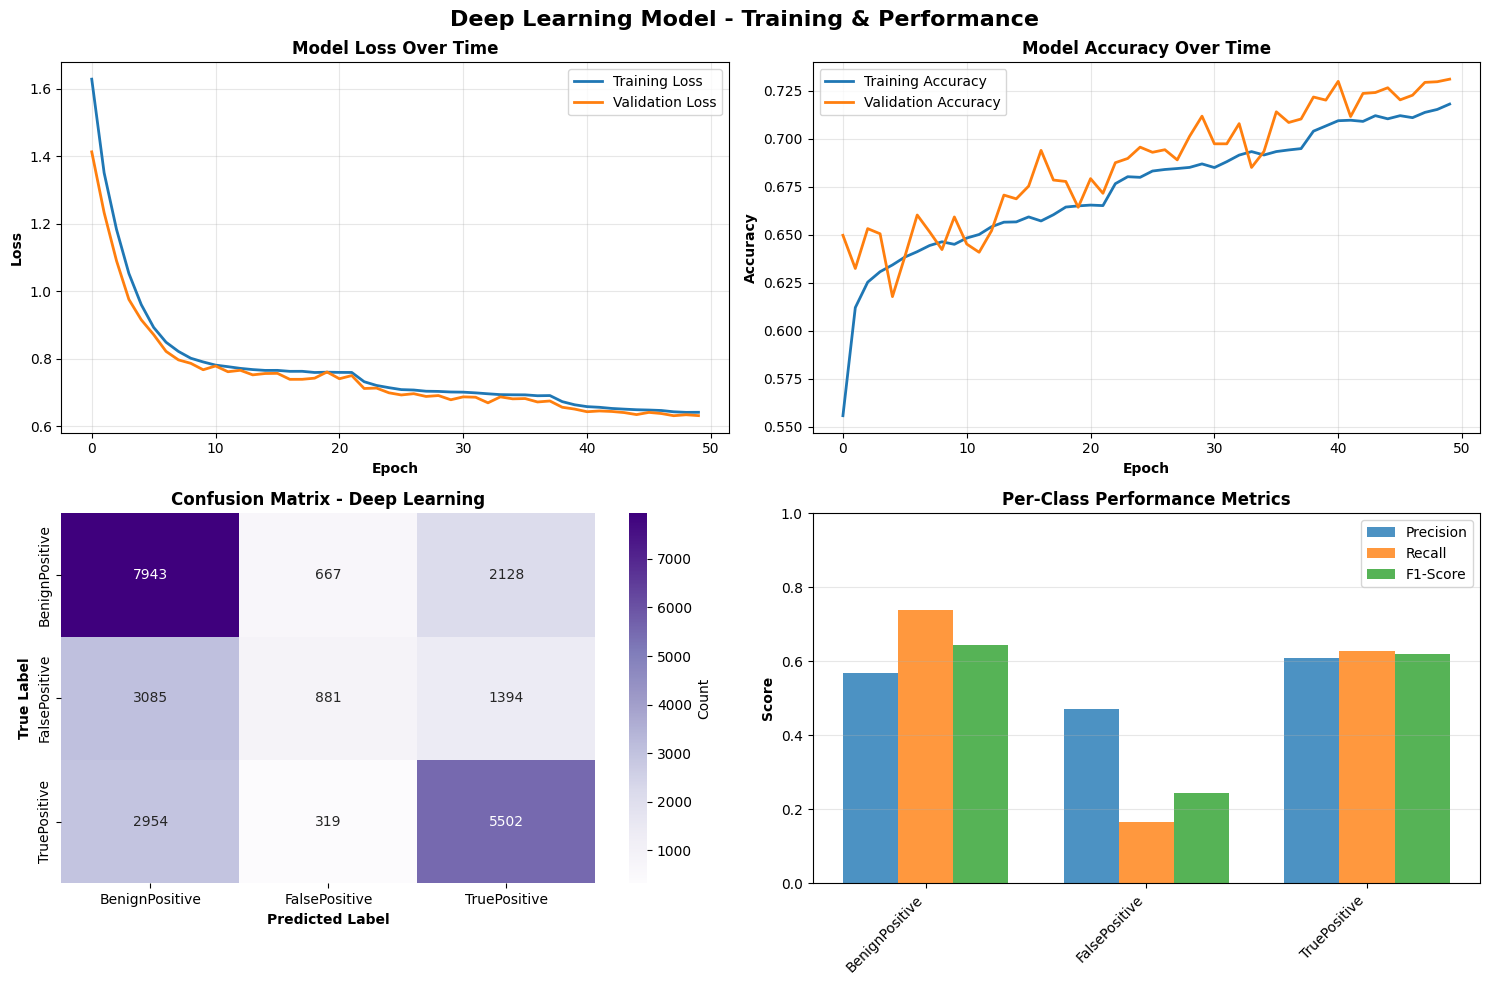

In [26]:
# visualize deep learning model training and performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training & Validation Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontweight='bold')
axes[0, 0].set_ylabel('Loss', fontweight='bold')
axes[0, 0].set_title('Model Loss Over Time', fontweight='bold', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Training & Validation Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontweight='bold')
axes[0, 1].set_ylabel('Accuracy', fontweight='bold')
axes[0, 1].set_title('Model Accuracy Over Time', fontweight='bold', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Count'}, ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix - Deep Learning', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('True Label', fontweight='bold')
axes[1, 0].set_xlabel('Predicted Label', fontweight='bold')
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred)
x = np.arange(len(le.classes_))
width = 0.25
axes[1, 1].bar(x - width, precision, width, label='Precision', alpha=0.8)
axes[1, 1].bar(x, recall, width, label='Recall', alpha=0.8)
axes[1, 1].bar(x + width, f1, width, label='F1-Score', alpha=0.8)
axes[1, 1].set_ylabel('Score', fontweight='bold')
axes[1, 1].set_title('Per-Class Performance Metrics', fontweight='bold', fontsize=12)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(le.classes_, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].set_ylim([0, 1])

plt.suptitle('Deep Learning Model - Training & Performance',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Visuals of key features
(e.g., feature importance, partial dependence, or key relationships)

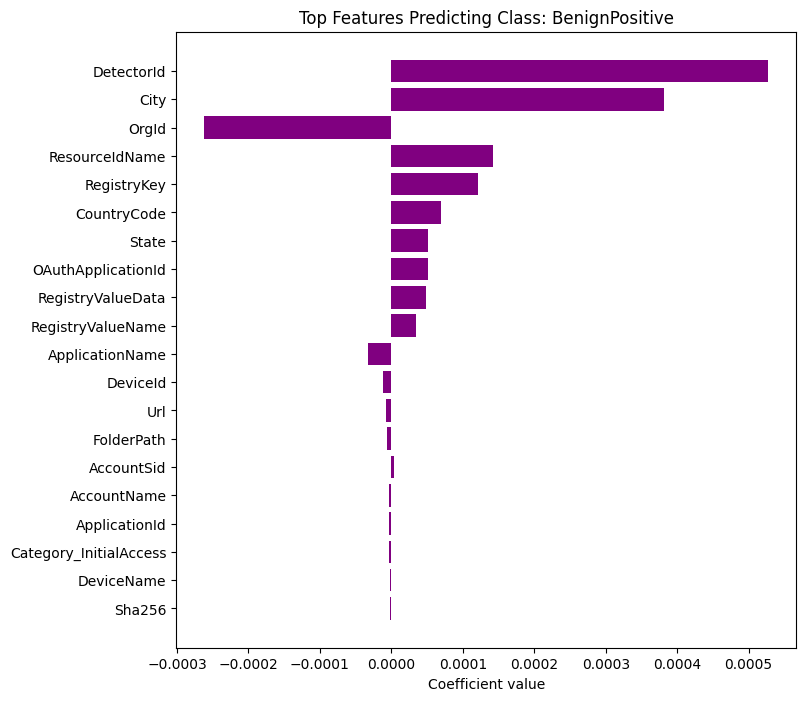

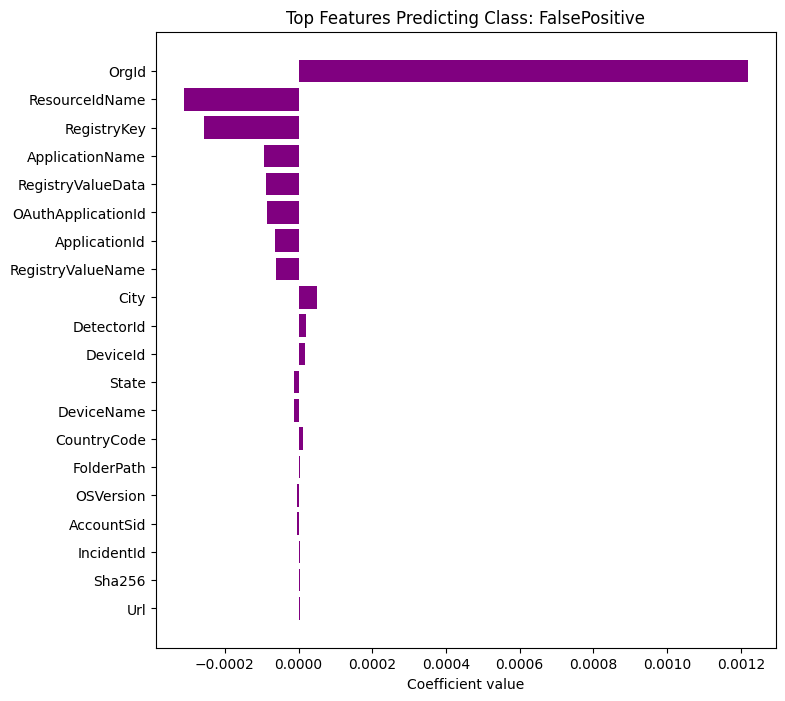

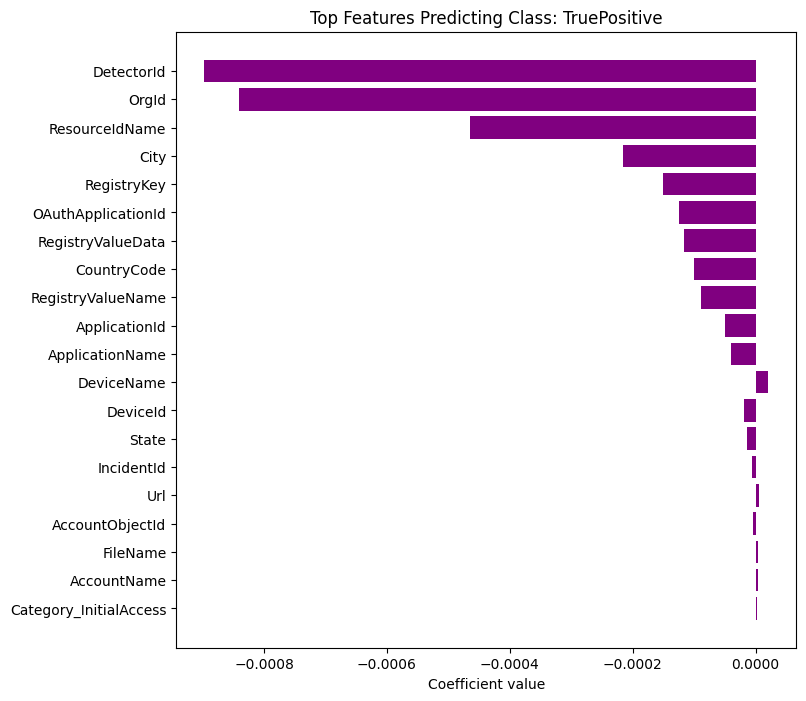

In [20]:
# feature importance visual
cat_features = lr_model.named_steps["preprocess"].named_transformers_["cat"].get_feature_names_out(cat_cols)
feature_names = np.concatenate([cat_features, num_cols])
coefs = lr_model.named_steps["classifier"].coef_

for class_index, class_name in enumerate(le.classes_):
    coef_df = pd.DataFrame({
        "feature": feature_names,
        "coef": coefs[class_index]
    })

    # get 5 strongest predictors
    top_5 = coef_df.reindex(coef_df.coef.abs().sort_values(ascending=False).index)[:20]

    # plot
    plt.figure(figsize=(8, 8))
    plt.barh(top_5["feature"], top_5["coef"], color="purple")
    plt.title(f"Top Features Predicting Class: {class_name}")
    plt.xlabel("Coefficient value")
    plt.gca().invert_yaxis()
    plt.show()


## Visuals of model performance
(e.g., actual vs predicted, residuals, confusion-matrix-like view)

In [22]:
# Imports
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

<Figure size 600x600 with 0 Axes>

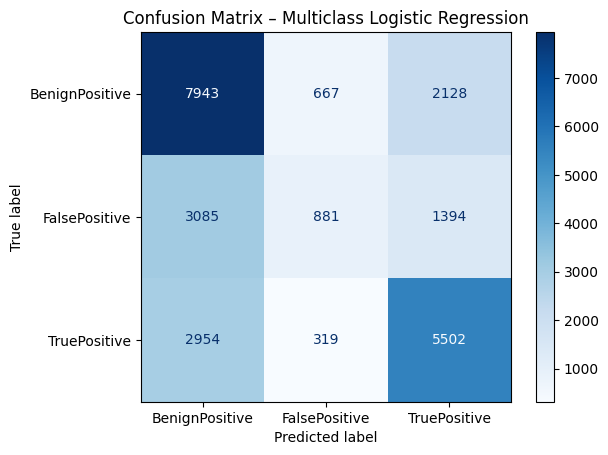

In [23]:
# make confusion matrix
y_pred = lr_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)

plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Multiclass Logistic Regression")
plt.show()

## What the model can be trusted for:
* **Logistic regression (LR) models** are interpretable, so we can see which features have strong predictive power and vice versa.
* Looking at the confusion matrix, the **LR model** appears to predict BenignPositive (8110 correct) and TruePositive (5582 correct) predictions well. Furthermore, for the BenignPositive class, precision, recall and the F1-score is 0.57, 0.75, and 0.65 respectively. High recall indicates that the model predicts these cases for the most part, while moderate precision indicates that some predictions are incorrect. Model performance for this class is good. For the TruePositive class, though, precision, recall and the F1-score is 0.61, 0.64, and 0.63 respectively. Model performance for this class is moderate.
* **XGBoost model** achieved 89.84% accuracy in classifying security incidents, which represents a significant 5.68% improvement over **Random Forest model**.
* The most important insight is the **XGBoost model's** 89.31% recall on TruePositive threats, meaning it successfully detects 89 out of every 100 real security incidents while maintaining a 93.48% precision, ensuring that when it flags something as a threat, it's correct 93% of the time. This balance is important for security operations because it means the model catches the a good majority of real threats without overwhelming analysts with false alarms.

## What the model cannot be trusted for:
* The **LR model** is accurate only 58% of the time.
* Looking at the confusion matrix, the **LR model** appears to predict FalsePositive incidents poorly. Compared to the other two classes, the model is correct for only 778 predictions. Furthermore, precision, recall, and the F1-score is 0.49, 0.15, and 0.22 respectively. This reaffirms that the model performs poorly, as only 15% of all FalsePositive cases are being detected.
* Other models didn't learn as well and had their trade offs, with a **deep learning model**, it took long and needs more epochs to train while **random forest** is a couple of seconds.